In [463]:
import pandas as pd
import numpy as np
import torch
import math
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [464]:
params={'figure.figsize':(16,10)}
plt.rcParams.update(params)

In [465]:
X=torch.linspace(0,100,1000).float()
y=(X+1)+torch.sin(X)*4+(torch.rand(len(X))-1/2)*20

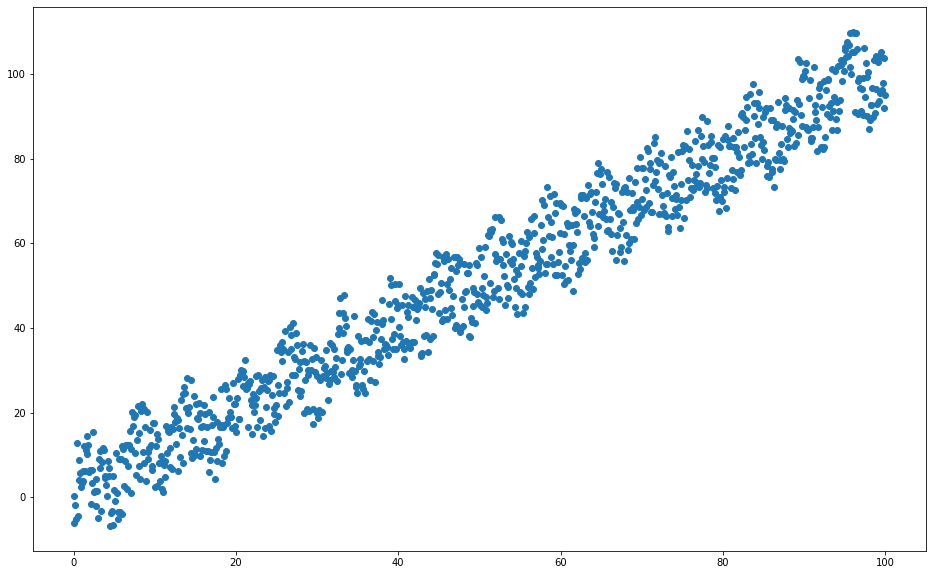

In [466]:
plt.plot(X,y,'o')

# LinearRegression

In [467]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()

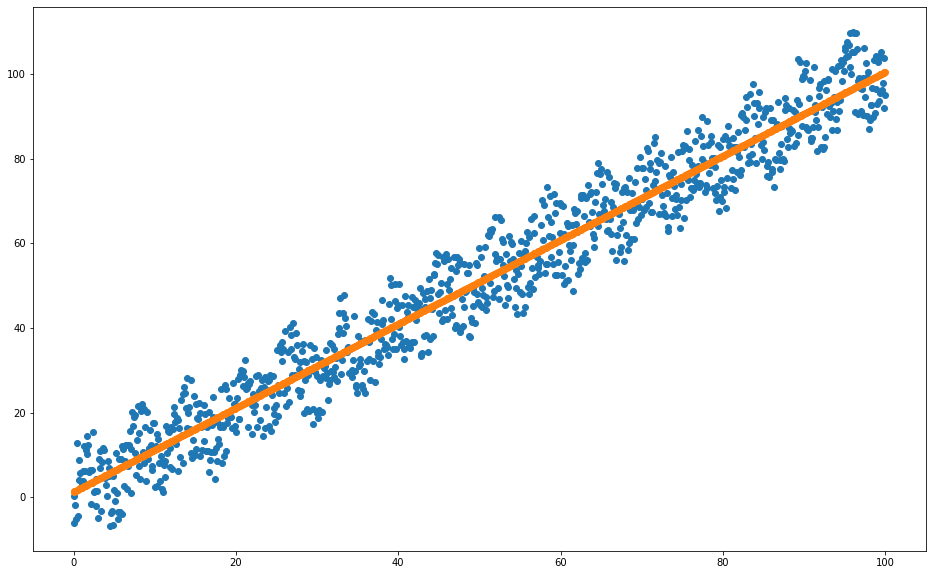

In [468]:
X_new=X.reshape(-1,1)
y_new=y.reshape(-1,1)
result=model.fit(X_new,y_new)
plt.plot(X,y,'o')
plt.plot(X,result.predict(X_new),'o')

In [469]:
class Onenet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ln=torch.nn.Linear(1,1)
    def forward(self,x):
        return self.ln(x)
n_one=Onenet()
optim=torch.optim.Adam(n_one.parameters(),lr=1e-3)
for epoch in range(30000):
    optim.zero_grad()
    y_pred=n_one.forward(X_new)
    loss=torch.sum((y_pred-y_new)**2)
    loss.backward()
    optim.step()
    
    

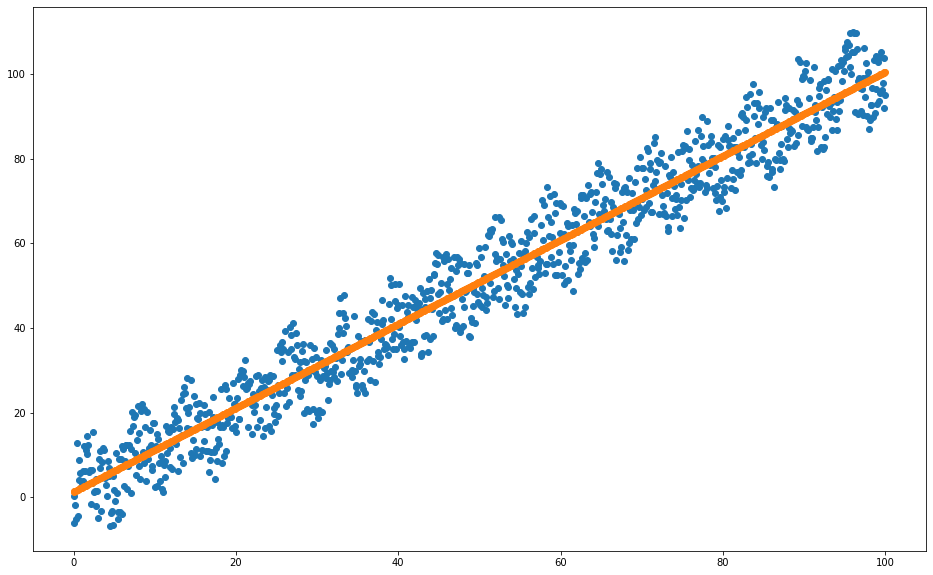

In [470]:
plt.plot(X,y,'o')
plt.plot(X,n_one.forward(X_new).detach().numpy(),'o')

# PCA+LogisticRegression

In [595]:
from sklearn import datasets
from sklearn import decomposition

In [596]:
iris=datasets.load_iris()
X=iris.data
y=iris.target

In [597]:
X.shape

(150, 4)

In [598]:
y.shape

(150,)

In [599]:
pca=decomposition.PCA(n_components=2)
X_cent=X-X.mean(axis=0)
pca.fit(X_cent)
x_pca=pca.transform(X_cent)

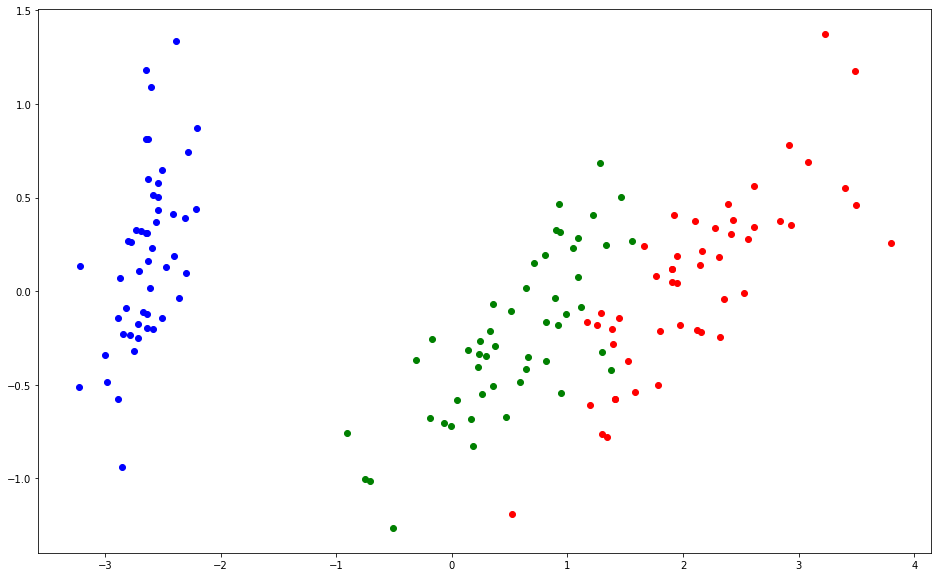

In [600]:
def plot_new(x,y,yy,color,i=True):
    if i:
        plt.plot(x[y==yy,0],x[y==yy,1],color)
    else:
        plt.plot(x[y!=yy,0],x[y!=yy,1],color)
plot_new(x_pca,y,0,'bo')
plot_new(x_pca,y,1,'go')
plot_new(x_pca,y,2,'ro')


In [601]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
X_new=X
result=model.fit(X_new,y.reshape(-1,1))
t=lambda y: sum(y)/len(y)
print(r2_score(result.predict(X_new),y))

0.9607740585774058


0.9504917816357515


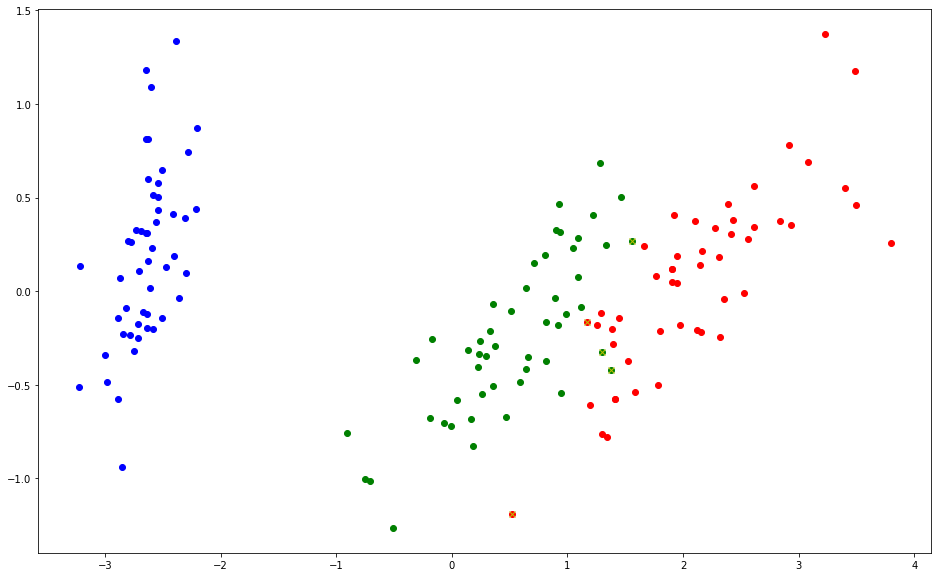

In [602]:
model2=LogisticRegression()
result2=model2.fit(x_pca,y.reshape(-1,1))
print(r2_score(result2.predict(x_pca),y))
plot_new(x_pca,y,0,'bo')
plot_new(x_pca,y,1,'go')
plot_new(x_pca,y,2,'ro')
plot_new(x_pca,y,result2.predict(x_pca),'yx',False)

In [603]:
class Onenet(torch.nn.Module):
    def __init__(self,input_data):
        super().__init__()
        self.fc=torch.nn.Linear(input_data,3)
        self.ac=torch.nn.Softmax()
    def forward(self,x):
        return self.fc(x)
    def predict(self,x):
        x=self.fc(x)
        return self.ac(x)

In [604]:
n_one=Onenet(4)
X_new=torch.from_numpy(X).float()
y_new=torch.from_numpy(y).long()
optim=torch.optim.Adam(n_one.parameters(),lr=1e-3)
loss=torch.nn.CrossEntropyLoss()
for epoch in range(3000):
    optim.zero_grad()
    y_pred=n_one.forward(X_new)
    loss_val=loss(y_pred,y_new)
    loss_val.backward()
    optim.step()
y_pred=n_one.predict(X_new)
y_pred=y_pred.argmax(dim=1)
print(r2_score(y_pred,y_new))

0.96


In [605]:
from tqdm import tqdm
n_one=Onenet(2)
X_new=torch.from_numpy(x_pca).float()
y_new=torch.from_numpy(y).long()
optim=torch.optim.Adam(n_one.parameters(),lr=1e-3)
loss=torch.nn.CrossEntropyLoss()
for epoch in tqdm(range(3000)):
    optim.zero_grad()
    y_pred=n_one.forward(X_new)
    loss_val=loss(y_pred,y_new)
    loss_val.backward()
    optim.step()
y_pred=n_one.predict(X_new)
y_pred=y_pred.argmax(dim=1)
print(r2_score(y_pred,y_new))

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 827.27it/s]

0.8348552554886342


# Дерево решений

In [482]:
# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

In [483]:
X_train,X_test,y_train,y_test=train_test_split(train_data,train_labels,train_size=0.8,shuffle=True)
X_train=torch.from_numpy(X_train)
X_test=torch.from_numpy(X_test)
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)

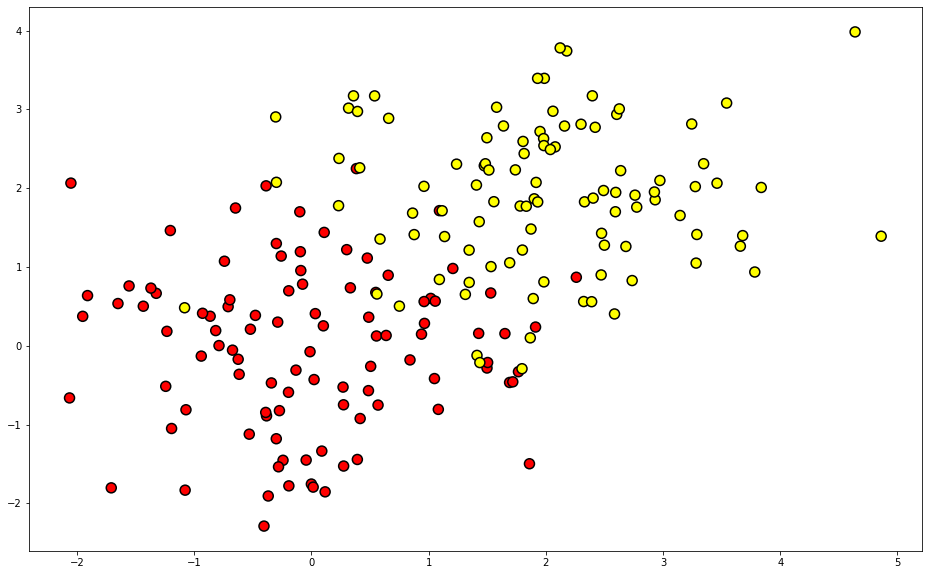

In [484]:
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

In [485]:
from sklearn.tree import DecisionTreeClassifier

In [514]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3,random_state=19)
clf_tree.fit(X_train, y_train)
pred=clf_tree.predict(X_test)

In [515]:
r2_score(pred,y_test)

0.4949494949494949

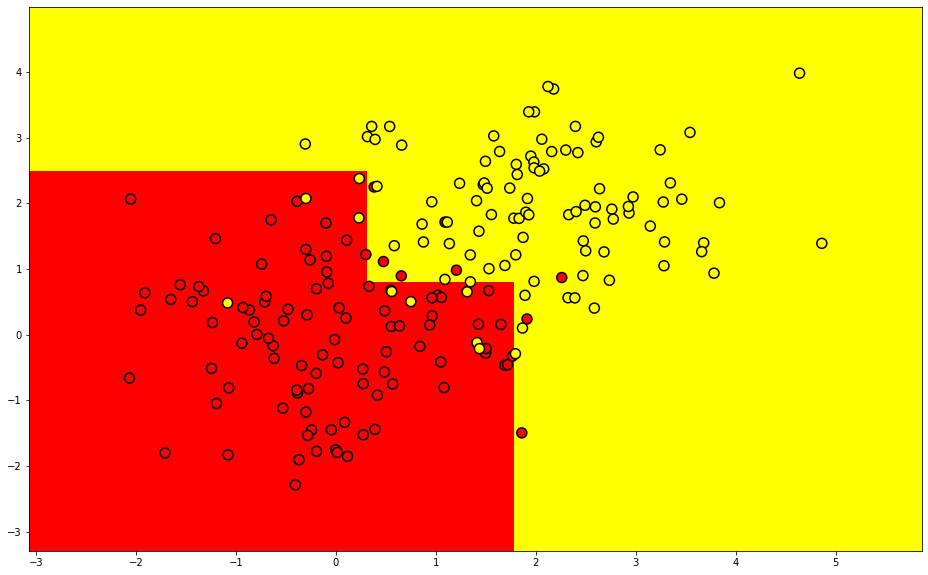

In [516]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

In [536]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [531]:
from sklearn.tree import DecisionTreeRegressor

In [564]:
clf_tree = DecisionTreeRegressor(max_depth=30,random_state=19)
clf_tree.fit(X_train, y_train)
pred=clf_tree.predict(X_test)

In [565]:
r2_score(pred,y_test)

0.9258854082643737

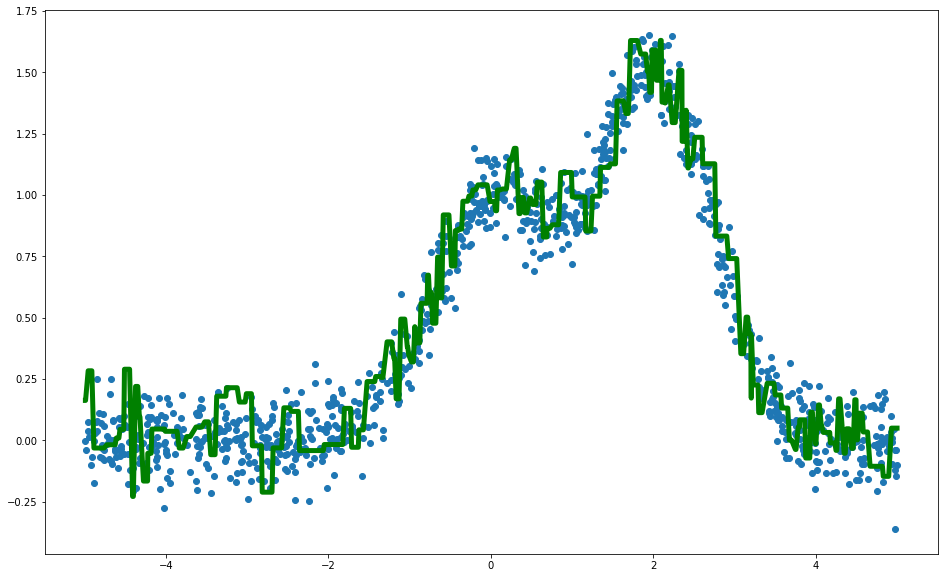

In [566]:
plt.plot(X_test,y_test,'o')
plt.plot(X_test,pred,'g',lw=5)

# K-neighbor

In [567]:
# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

In [568]:
X_train,X_test,y_train,y_test=train_test_split(train_data,train_labels,train_size=0.8,shuffle=True)
X_train=torch.from_numpy(X_train)
X_test=torch.from_numpy(X_test)
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)

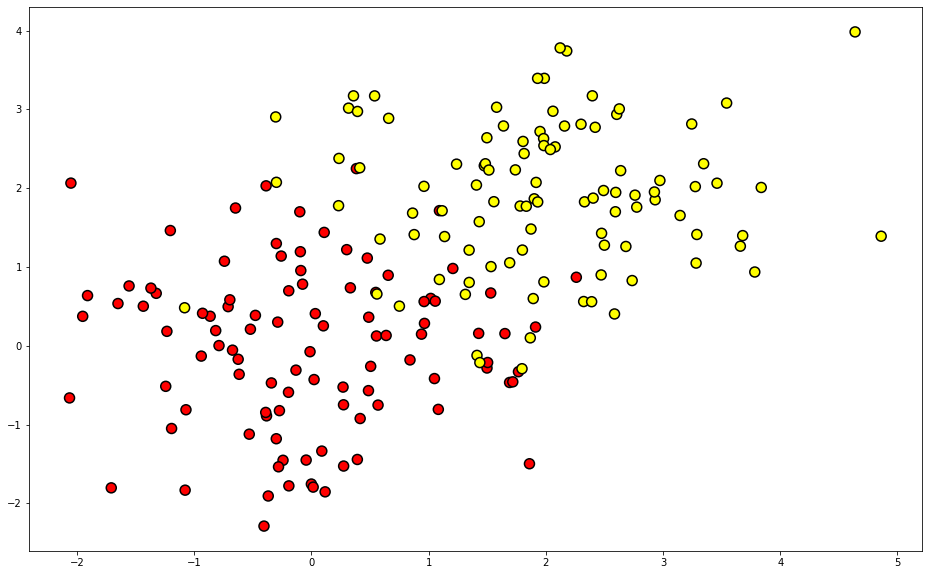

In [569]:
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

In [570]:
from sklearn.neighbors import KNeighborsClassifier

In [583]:
knn = KNeighborsClassifier(n_neighbors=10,metric='minkowski')#число ближайших соседей метрика
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [584]:
from sklearn.metrics import accuracy_score
knn_pred = knn.predict(X_test)
accuracy_score(y_test, knn_pred) # 0.88

0.95

# Случайный лес

In [585]:
from sklearn.ensemble import RandomForestClassifier


In [580]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=19)
forest.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=19)

In [582]:
accuracy_score(y_test, forest.predict(X_test))

0.9